# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


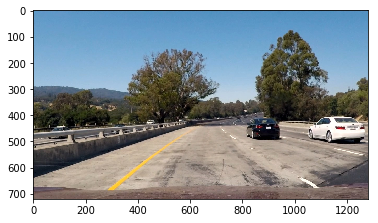

In [2]:
#reading in an image
image = mpimg.imread('CarND-Advanced-Lane-Lines-master/test_images/test1.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image) 

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


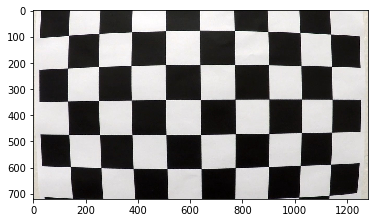

In [3]:
#reading in an image
image2 = mpimg.imread('CarND-Advanced-Lane-Lines-master/camera_cal/calibration1.jpg')

#printing out some stats and plotting
print('This image is:', type(image2), 'with dimensions:', image2.shape)
plt.imshow(image2) 

## Calibrate Cameras

<class 'numpy.ndarray'> (45, 1, 2)


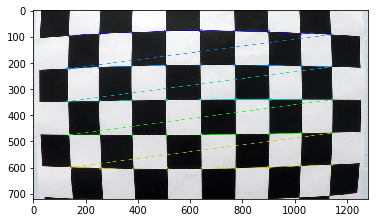

In [4]:
def find_corners(fname, nx, ny):
    # Make a list of calibration images
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    return ret, corners, img

nx = 9
ny = 5
fname = 'CarND-Advanced-Lane-Lines-master/camera_cal/calibration1.jpg'
ret, corners, img = find_corners(fname, nx, ny)
plt.imshow(img)
print(type(corners),corners.shape)

<class 'numpy.ndarray'> (54, 1, 2)


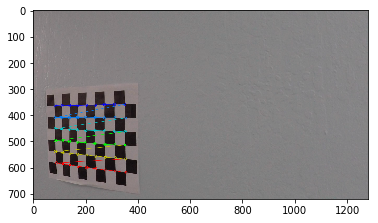

In [5]:
nx = 9
ny = 6
fname = 'CarND-Advanced-Lane-Lines-master/camera_cal/calibration20.jpg'
ret, corners, img = find_corners(fname, nx, ny)
plt.imshow(img)
print(type(corners),corners.shape)

In [6]:
def calibrate(nx, ny):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./CarND-Advanced-Lane-Lines-master/camera_cal/cal*.jpg')
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        ret, corners, img = find_corners(fname, nx, ny)
        
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            #cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            #write_name = './CarND-Advanced-Lane-Lines-master/camera_cal/calibrated_images/corners_found'+str(idx)+'.jpg'
            #cv2.imwrite(write_name, img)
    
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    #cv2.destroyAllWindows()
    return ret, mtx, dist, rvecs, tvecs


ret, mtx, dist, rvecs, tvecs = calibrate(nx, ny)

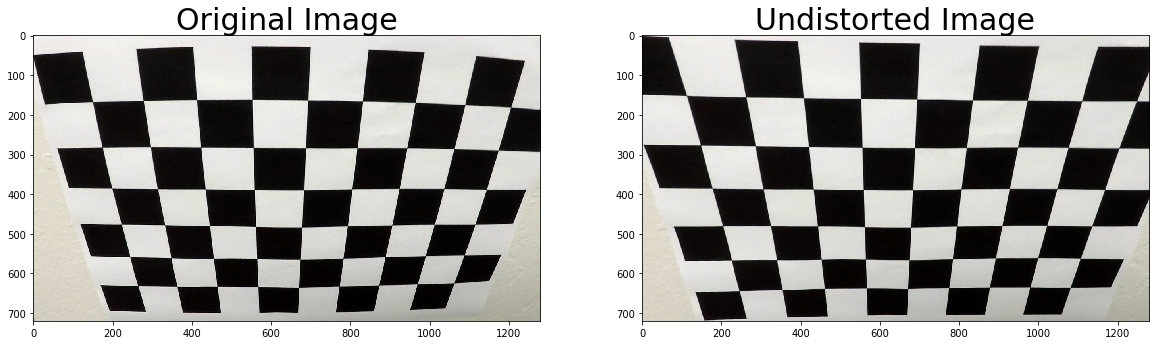

In [7]:
%matplotlib inline

#Test the results of the calibration
img_original = mpimg.imread('./CarND-Advanced-Lane-Lines-master/camera_cal/calibration2.jpg')
img_undistorted = cv2.undistort(img_original, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_original)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

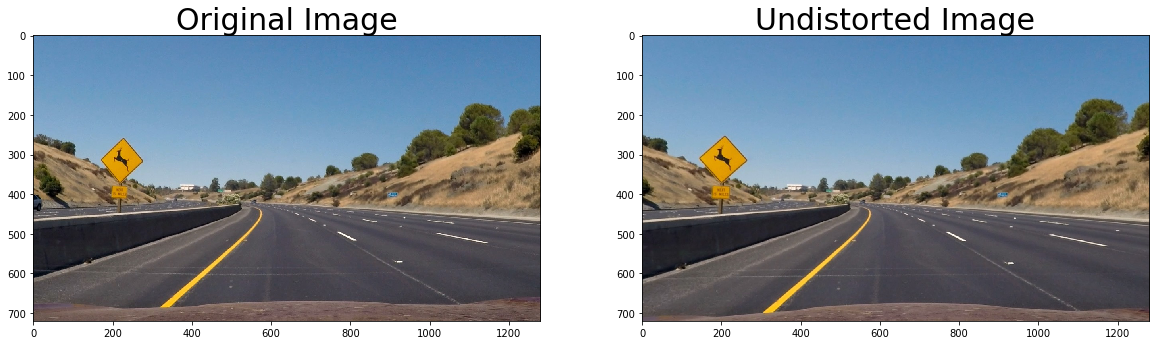

In [8]:
#Now to apply undistortion to actual road images
img_original = mpimg.imread('./CarND-Advanced-Lane-Lines-master/test_images/test2.jpg')
img_undistorted = cv2.undistort(img_original, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_original)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

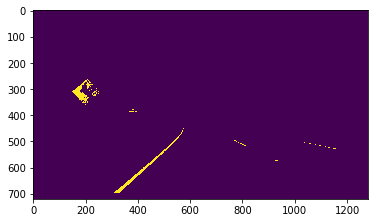

In [9]:
def binary_s_threshold(img, thresh):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    S = hsv[:,:,2]

    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 255
    return binary

s_binary = binary_s_threshold(img_undistorted, thresh = (225,255))
plt.imshow(s_binary)

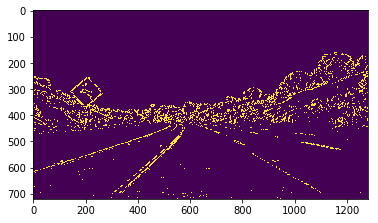

In [10]:
def sobel_x(img, thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 60
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 255
    return sxbinary 
sobel_binary = sobel_x(img_undistorted, thresh = (20,100))
plt.imshow(sobel_binary)

49935
(720, 1280, 3)


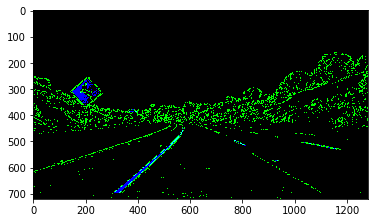

In [11]:
color_binary = np.dstack((np.zeros_like(sobel_binary), sobel_binary, s_binary))
print(np.count_nonzero(color_binary))
print(color_binary.shape)
plt.imshow(color_binary)

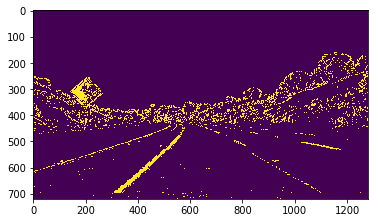

In [12]:
combined_binary = np.zeros_like(sobel_binary)
combined_binary[(s_binary == 255) | (sobel_binary == 255)] = 1
plt.imshow(combined_binary)

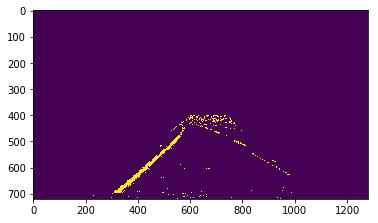

In [13]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

imshape = image.shape
top_right_vertex = (740,400)
top_left_vertex = (600,400)
bottow_right_vertex = (1080,imshape[0])
bottom_left_vertex = (200,imshape[0])
vertices = np.array([[bottom_left_vertex,top_left_vertex, top_right_vertex, bottow_right_vertex]], dtype=np.int32)
cropped_combined_binary = region_of_interest(combined_binary, vertices)
plt.imshow(cropped_combined_binary)

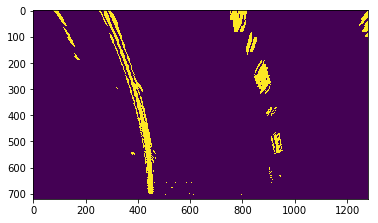

In [14]:
def perspective_transform(undistorted_image):
    # For source points I'm grabbing the outer four detected corners
    src = np.float32([[200,700],[597,450],[686,450],[1110,700]])
    dst = np.float32([[380,700],[400,0],[900,0],[921,700]])
    # Given src and dst points, calculate the perspective transform matrix
    img_size = (undistorted_image.shape[1], undistorted_image.shape[0]) 
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undistorted_image, M, img_size)

    # Return the resulting image and matrix
    return warped, M

warped, M = perspective_transform(cropped_combined_binary)
plt.imshow(warped)
#I'm not seeing much point in using the sobel at all??

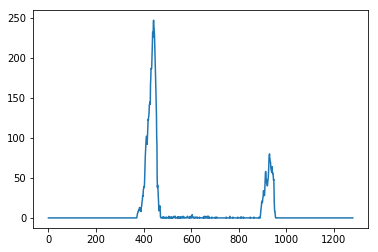

In [15]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

(720, 0)

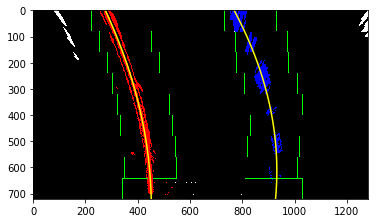

In [16]:
def sliding_window_blind(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    
    return ploty, left_fit, right_fit, left_fitx, right_fitx, out_img
    
ploty, left_fit, right_fit, left_fitx, right_fitx, out_img = sliding_window_blind(warped)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

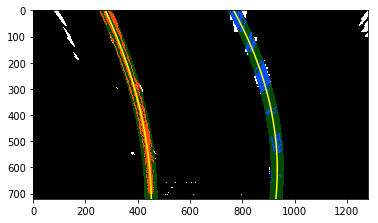

In [17]:
def neighborhood_search(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 25
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return ploty, left_fit, right_fit, left_fitx, right_fitx, result

ploty, left_fit, right_fit, left_fitx, right_fitx, out_img = neighborhood_search(warped, left_fit, right_fit)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

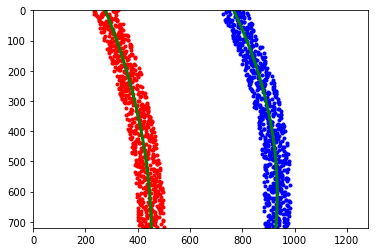

In [18]:
def fake_data_lane_lines(ploty, left_fit, right_fit):
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([left_fit[0]*y**2 + left_fit[1]*y + left_fit[2] + np.random.randint(-50, high=51) for y in ploty])
    rightx = np.array([right_fit[0]*y**2 + right_fit[1]*y + right_fit[2] + np.random.randint(-50, high=51) for y in ploty])
    #rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) for y in ploty])

    #leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2] + np.random.randint(-50, high=51)
    #rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] + np.random.randint(-50, high=51)
    
    #leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    #rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    # = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return leftx, rightx
    
leftx, rightx = fake_data_lane_lines(ploty, left_fit, right_fit)
# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [19]:
def find_curvature_and_offset(ploty, leftx, rightx, left_fit, right_fit):    
    #Find lane curvature
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # Example values: 632.1 m    626.2 m
    
    #Find offset from ceter of lane.
    vehicle_midpoint = 1280/2.
    left_intercept = left_fit[0]*y_eval**2+left_fit[1]*y_eval+left_fit[2]
    right_intercept = right_fit[0]*y_eval**2+right_fit[1]*y_eval+right_fit[2]
    lane_midpoint = (left_intercept + right_intercept) / 2.
    offset = (vehicle_midpoint - lane_midpoint) * xm_per_pix
    
    return left_curverad, right_curverad, offset

left_curverad, right_curverad, offset = find_curvature_and_offset(ploty, leftx, rightx, left_fit, right_fit)
print(left_curverad, 'm', right_curverad, 'm', offset, 'm')

483.496940817 m 386.199227584 m -0.265178787678 m


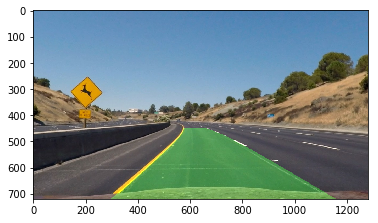

In [20]:
from numpy.linalg import inv
def draw_lines_on_unwarped(warped, ploty, left_fitx, right_fitx, M, undist):
    Minv = inv(M)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

result = draw_lines_on_unwarped(warped, ploty, left_fitx, right_fitx, M, img_undistorted)

plt.imshow(result)

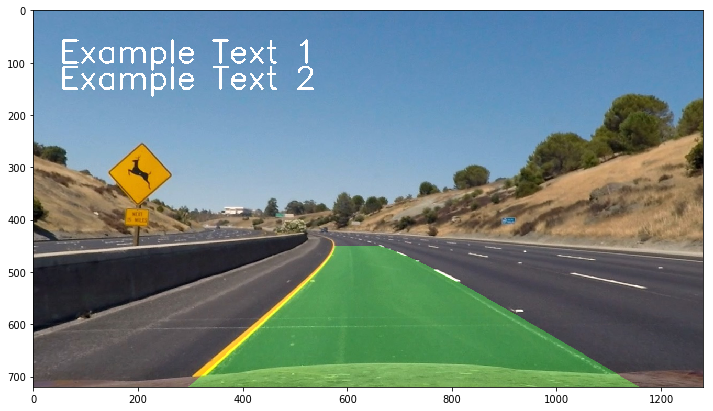

In [21]:
def print_text_on_image(img,text1,text2):
    text_image = cv2.putText(img,text1, (50,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 4)
    text_image = cv2.putText(text_image,text2, (50,150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 4)
    return text_image
text_image = print_text_on_image(result,'Example Text 1','Example Text 2')

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)

ax.imshow(text_image)

## Lines Class

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

In [22]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [23]:
l = Line()
l.detected = True
l.detected

True

In [31]:
class Frame():
    def __init__(self):
        self.number = 0
        self.left_fit_list = []
        self.right_fit_list = []
        self.curvature = 0
        self.offset = 0
        
    def next_frame(self):
        self.number += 1

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

In [25]:
#IDEA: Develop a 'Confidence' metric that the algoritm can use to decide whether or not to 
#keep/use a detected line, and can be printed out on the screen (similar to the colors I did 
#in the first project)


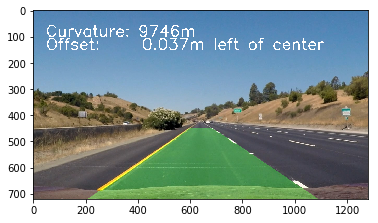

In [42]:
frame = Frame()
#PIPELINE - Each image in the video will be run through this pipline.
def process_image(image, mtx = mtx, dist = dist):
    #Distortion Correction
    img_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    
    #Thresholding
    s_binary = binary_s_threshold(img_undistorted, thresh = (225,255))
    sobel_binary = sobel_x(img_undistorted, thresh = (20,100))
    combined_binary = np.zeros_like(sobel_binary)
    combined_binary[(s_binary == 255) | (sobel_binary == 255)] = 1
    
    #Cropping
    imshape = image.shape
    top_right_vertex = (800,400)
    top_left_vertex = (500,400)
    bottow_right_vertex = (1200,imshape[0])
    bottom_left_vertex = (80,imshape[0])
    vertices = np.array([[bottom_left_vertex,top_left_vertex, top_right_vertex, bottow_right_vertex]], dtype=np.int32)
    cropped_combined_binary = region_of_interest(combined_binary, vertices)
    
    #Perspective Transform
    warped, M = perspective_transform(cropped_combined_binary)
    
    #Determine frame <some other attribute from Line()> 
    frame.next_frame()
    #Detect Lane Lines
        #Needs to be able to decide (based on Lines() class) whehter to use blind sliding window or fast sliding window.
    if (frame.number < 4): #Only uses blind function the first time.
        ploty, left_fit, right_fit, left_fitx, right_fitx, _ = sliding_window_blind(warped)
        frame.left_fit_list.append(left_fit)
        frame.right_fit_list.append(right_fit)
    else:
        #average the last three lines
        left_fit = np.mean( np.array([ frame.left_fit_list[-3:-2],frame.left_fit_list[-2:-1],frame.left_fit_list[-1:]]), axis=0 )
        right_fit = np.mean( np.array([ frame.right_fit_list[-3:-2],frame.right_fit_list[-2:-1],frame.right_fit_list[-1:]]), axis=0 )
        left_fit = left_fit[0]
        right_fit = right_fit[0]
        ploty, left_fit, right_fit, left_fitx, right_fitx, result = neighborhood_search(warped, left_fit, right_fit)
        frame.left_fit_list.append(left_fit)
        frame.right_fit_list.append(right_fit)
        
    #Determine Curvature and Lane Center Offset
    curvature = frame.curvature
    offset = frame.offset
    if(frame.number % 9 == 0 or frame.number == 1):
        leftx, rightx = fake_data_lane_lines(ploty, left_fit, right_fit)
        left_curverad, right_curverad, offset = find_curvature_and_offset(ploty, leftx, rightx, left_fit, right_fit)
        curvature = int((left_curverad + right_curverad) / 2.)
        frame.curvature = curvature
        frame.offset = offset

    #Tracking and smoothing lines
        #Using Line() class. 
        #See Tips and Tricks for Project page.
        #Include sanity-check function to throw out lines from bad frames.
    #IDEA: using left_fit and right_fit, if the new line is drastically different (any of the 3 params changes by some percentage)
    #then the line is considered to not have been found. This is your 'Confidence' measure.
    #

    #Draw Lane Lines
    lines_drawn = draw_lines_on_unwarped(warped, ploty, left_fitx, right_fitx, M, image)
    
    
    #Print text on Image
    text1 = 'Curvature: '+str(curvature)+'m' 
    if (offset < 0):
        text2 = 'Offset: '+"{:9.3f}".format(-offset)+'m left of center'
    else:
        text2 = 'Offset: '+"{:9.3f}".format(offset)+'m right of center'
    
    result = print_text_on_image(lines_drawn,text1,text2)
    
    return result

image = mpimg.imread('./CarND-Advanced-Lane-Lines-master/test_images/straight_lines1.jpg')
result = process_image(image, mtx, dist)
plt.imshow(result)

In [43]:
import imageio
imageio.plugins.ffmpeg.download()

In [44]:
frame = Frame()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#Create new video
white_output = './CarND-Advanced-Lane-Lines-master/output_videos/project_video.mp4'
clip1 = VideoFileClip('./CarND-Advanced-Lane-Lines-master/project_video.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./CarND-Advanced-Lane-Lines-master/output_videos/project_video.mp4
[MoviePy] Writing video ./CarND-Advanced-Lane-Lines-master/output_videos/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:14<00:00,  5.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./CarND-Advanced-Lane-Lines-master/output_videos/project_video.mp4 

Wall time: 4min 16s


In [45]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [36]:
#Now to try the challenge
frame = Frame()
#Create new video
challenge_output = './CarND-Advanced-Lane-Lines-master/output_videos/challenge_video.mp4'
clip2 = VideoFileClip('./CarND-Advanced-Lane-Lines-master/challenge_video.mp4')
challenge_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video ./CarND-Advanced-Lane-Lines-master/output_videos/challenge_video.mp4
[MoviePy] Writing video ./CarND-Advanced-Lane-Lines-master/output_videos/challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:36<00:00,  5.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./CarND-Advanced-Lane-Lines-master/output_videos/challenge_video.mp4 

Wall time: 1min 38s


In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))